# bayesian curve fitting

We are given a set of N data points (x,y) and all the y values have some added constant noise $\sigma$. Find the parameters $a_i$ such that y can be written in terms of a set of M basis functions $f_i:  y=\sum_i^M a_i f_i(x)$ <br>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats
import math
import random
from sklearn import linear_model
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

In [2]:
#define the underlying function (polynomial)
weights=[np.random.uniform(-0.5,0.5) for i in range(0,5)]
def f(x,weights):
    y=0
    for i in range(0,len(weights)):
        y+=weights[i]*np.power(x,i)
    return y

#parameters sigma and M
sigma=np.random.uniform(0,0.1) #constant noise
M=3 #number of basis functions

#generate some input data and add noise
N=30 #number of data points
input_data=[(lambda x:(x,f(x,weights)+sigma))(np.random.uniform(-2,2)) for i in range(0,N)]

x_data, y_data = [[ i for i, j in input_data ],[ j for i, j in input_data ]] #unzip the tuples in input_data
x_data=np.array(x_data)
y_data=np.array(y_data)

### predict parameters $a_i$ distribution knowing $\sigma$ and $M$ using sampling (computational Bayesian inference)


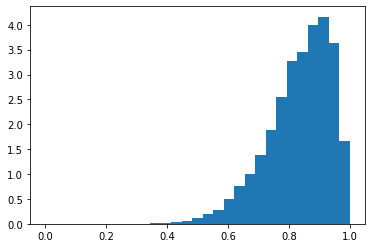

In [3]:
# easy example for this method : biased coin (p=prob of heads) is tossed n=10 times and we get x=9 heads
# using the prior distribution p ∼ U [0, 1], find the posterior distribution

p_samp = np.random.uniform(size=10000)
n,x=10,9
prx = p_samp**x * (1-p_samp)**(n-x)
w=prx/np.sum(prx) #calculate the weights

#plot the result as a histogram
plt.hist(p_samp, weights=w, density=True, bins=np.linspace(0,1,30))
plt.show()

In [4]:
# calculate the joint log likelihood distribution 
def pr_joint(x_data,y_data,sigma,M,a):
    """returs the log likelihood"""
    f_data=[0]*len(x_data)
    for i in range (0,len(x_data)):
        for j in range(0,M):
            f_data[i]+=a[j]*np.power(x_data[i],j)
    return -len(x_data)*np.log(abs(sigma))-np.sum((np.array(y_data)-np.array(f_data))**2)/(2*sigma**2) #remove the exp so it doesn't blow up/too small


# take many samples for the parameters (in this case assume y ~ a0 + a1 x + a2 x^2)
nr_samp=100000 #need at least 10^6 samples for a good result
a_samp=[np.random.uniform(low=-5,high=5,size=M) for i in range(0,nr_samp)]
sigma_samp=np.random.uniform(low=-0.2,high=0.2,size=nr_samp) # sample for sigma
pr_samp=[0]*nr_samp #likelihood of each sample

for i in range(0,nr_samp):
    pr_samp[i]=pr_joint(x_data,y_data,sigma,M,a_samp[i])

# make all loglik positive by adding a constant for the distribution to make sense
min_pr=np.min(pr_samp)
pr_samp_positive=[pr - min_pr for pr in pr_samp]
    
# find the distribution for a0, a1, a2 and the weights
a0, a1, a2 = [[ i for i,j,k in a_samp ],[ j for i,j,k in a_samp ],[ k for i,j,k in a_samp ]] #unzip the tuples
w=pr_samp_positive/np.sum(pr_samp_positive) #calculate the weights




In [6]:
# compare the results with the one obtained from least squares + the true value for sigma
print(a0[np.argmax(w)],a1[np.argmax(w)],a2[np.argmax(w)],sigma_samp[np.argmax(w)])
print(least_squares(M,x_data,y_data),sigma)

0.06862359164514054 0.9222745403641133 0.04668968346586766 0.13144330549630628
[0.         0.77563361 0.00752503] 0.08240552877693316


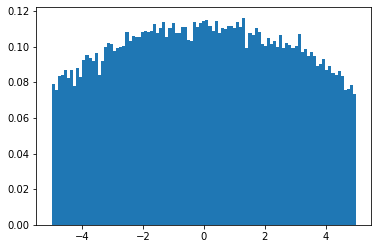

In [19]:
# plot histograms for a0,a1,a2
plt.hist(a2,weights=w,density=True,bins=np.linspace(-5,5,100 ))
plt.show()

# distribution for a0, sigma are almost uniform
# distribution for a1, a2 show results close to least squares estimates

### predict best fit parameters $a_i$ using least squares estimation



In [5]:
def least_squares(M,x_data,y_data):
    """returs the best fit coefficiets for a polyomial fit"""
    one=[1]*len(x_data)
    nr_feat=M
    feat=np.column_stack([x_data**i for i in range(0,nr_feat)])
    
    model = linear_model.LinearRegression()
    model.fit(feat,y_data)
    return model.coef_

a=least_squares(3,x_data,y_data)
print(a)

y_predicted=[0]*len(x_data)
for i in range(0,len(a)):
    y_predicted+=a[i]*x_data**i

# residuals=abs(np.array(y_predicted)-y_data)
# plt.plot(x_data,y_data,'x')
# plt.plot(x_data,y_predicted,'o')
# plt.show()

# plt.ylim(min(residuals),max(residuals))
# plt.plot(x_data,residuals,'o')
# plt.show()

[0.         0.77563361 0.00752503]


### find posterior distrib for all random variables unknown (i.e. $a_i, \sigma, M$)
computational Bayesian inference <br>

$V(M)=\sum_i y_i^2 \; - \sum_i \sum_j y_j a_i f_i(x_j)$ <br>
=> final expression: $-\frac{1}{\sigma^2}\sum_i y_i^2 \; + (\frac{1}{\sigma^2} - \frac{\beta}{2(1+\beta \sigma^2)})\; \sum_i \sum_j y_j a_i f_i(x_j)$

### probability distribution in terms of the number of parameters $M$

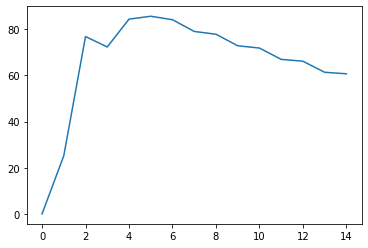

In [20]:
# posterior distribution for M from the paper

N=len(x_data)
def prob_M(M,a,x_data,y_data):
    V0=sum(np.array(y_data)**2)
    VM=V0
    for i in range(0,len(y_data)):
        for j in range(0,M):
            VM-=y_data[i]*a[j]*x_data[i]**j
    log_pr=np.log(math.factorial(int(M/2)))+np.log(math.factorial(int((N-M)/2)))+(N-M)/2*np.log(V0/abs(VM))
    return log_pr

max_M=15 
nr_M=[0]*max_M
log_M=[0]*max_M
for i in range(1,max_M):
    nr_M[i]=i
    a=least_squares(nr_M[i],x_data,y_data)
    log_M[i]=prob_M(nr_M[i],a,x_data,y_data)

plt.plot(nr_M,log_M)
plt.show()



In [ ]:
#